<a href="https://colab.research.google.com/github/ardadastan04/projects/blob/main/Final_Copy_of_adastan_MLab_Onboarding_Project_Fall_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLab Onboarding Project, Fall 2023

Your task is to classify different species of birds! See the project document pinned in \#mlab-general for more details.

## Setup

In [ ]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Now run the rest of your code

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/project'
FOLDERNAME = 'My Drive/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
PATH = '/content/drive/{}'.format(FOLDERNAME)
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/My Drive/project


In [ ]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn

# Data processing
import pandas as pd

# Data transformations
import torchvision

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm

# Other
import time
from datetime import date

In [ ]:
# Set PyTorch to use the GPU
device = torch.device('cuda')

## Dataset

You'll need to create a way to load our training images into PyTorch.

Ordinarily, you would load images one at a time from a folder on your computer (or in our case, Google Drive). However, since Google Drive's file reading speed is extremely slow (on the order of 1 hour for the training dataset), this is inefficient for developing a model. Note that this *wouldn't* be the case if we were running locally, where file reading is much faster.

Since we still want you to get experience with creating an image dataset, we'll have you create it the traditional way (by loading images one at a time) on a **small dataset** that won't be used for actual training.

For the actual training dataset, we created an `h5py` bundle of the data, which allows you to read a single (larger) file to get a full list of images. Instead of reading the images individually, you'll be able to use the functions provided in `utils.py` to load lists of the images, labels, and classes.

### Loading images individually

Fill in the following class to load images one by one into a dataset. We provide a `csv_path` as an argument.

1. Load the CSV file using Pandas. The CSV is formatted as follows:
```
filepath,label,class
small_data/0 - GREAT XENOPS/0_1.jpg,0,GREAT XENOPS
...
small_data/2 - OSPREY/2_15.jpg,2,OSPREY
```

2. For each row of the CSV, read in the image at the `filepath`, and add the image and label to the `self.images` and `self.labels` list.

  We can load images with `Image.open(filename)`.

  We'll also want to keep track of the classes themselves, so `self.classes[0]` should equal the name of the bird with label 0 (`"GREAT XENOPS"`).

3. Fill in the rest of the functions based on the `self.images`, `self.labels`, and `self.classes` variables.

In [ ]:
from os import read
import csv

class BirdDatasetSmall(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.images = []
        self.labels = []
        self.classes = []

        for _, row in self.data.iterrows():
            filename = row['filepath']
            img = Image.open(filename)
            self.images.append(img)
            self.labels.append(int(row['label']))
            self.classes.append(row['class'])

        assert len(self.images) == len(self.labels)

    def load_image(self, idx):
        filename = self.data.iloc[idx]['filepath']
        print(f"Loading image: {filename}")
        img = Image.open(filename)
        return img, self.data.iloc[idx]['label'], self.data.iloc[idx]['class']

    def __len__(self):
        return len(self.data)

    def num_classes(self):
        return len(self.classes)

    def get_class(self, label):
        return self.classes[label]

    def get_image(self, idx):
        return self.images[idx]

    def get_label(self, idx):
        return self.labels[idx]

    def __getitem__(self, idx):
        return self.load_image(idx)

    def display(self, idx):
        display(self.get_image(idx))

#### Testing BirdDatasetSmall

First, we'll run some basic tests to make sure the dataset is reading the right values. The first time you run this cell, it might take about a minute to load the data.

In [ ]:
def test_case(message, value, expected_value):
    print(message)
    if value == expected_value:
        print("  PASSED")
    else:
        print(f"  EXPECTED: {expected_value}")
        print(f"  GOT: {value}")

small_dataset = BirdDatasetSmall("/content/drive/My Drive/project/small_data.csv")

test_case("Length of the dataset", len(small_dataset), 45)
test_case("Label of idx=17", small_dataset.get_label(17), 1)

Length of the dataset
  PASSED
Label of idx=17
  PASSED


Next, we'll display some images from the dataset. The output of running the cell should match the following image:

![](https://drive.google.com/uc?export=view&id=1mqvn-KXh8mWV6HcxulAnNqDhIPPWCq6f)

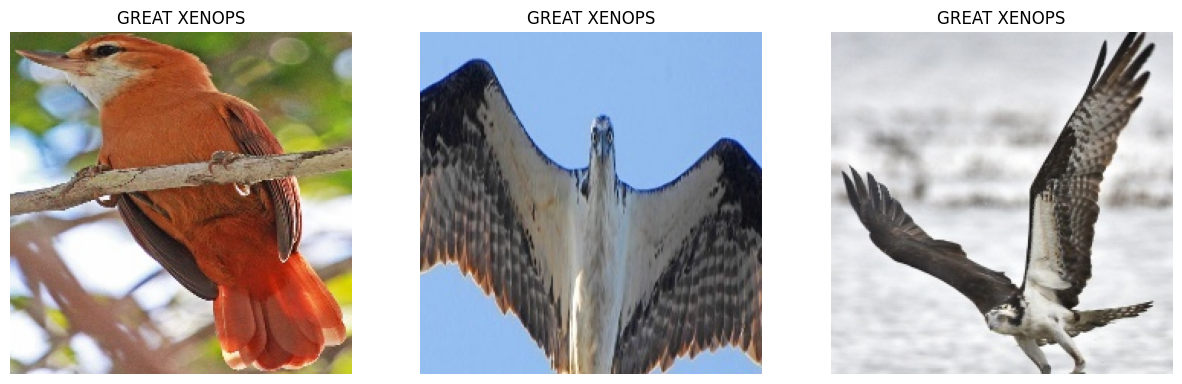

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 1
num_cols = 3

ds_idx = [13, 30, 43]
for plot_idx, idx in enumerate(ds_idx):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    ax.title.set_text(small_dataset.get_class(small_dataset.get_label(idx)))
    plt.axis('off')
    plt.imshow(small_dataset.get_image(idx))

### Loading images from a bundle

As mentioned previously, for Colab performance reasons we'll be loading all the training data from a pre-created HDF5 bundle.

You'll be filling in the same code as the previous dataset, but instead of loading images one by one, you will use the `utils.load_data()` function, which returns a tuple of a list of images, a list of labels, and a list of classes.

The other difference is the inclusion of a `transform` parameter. This is a `torchvision` Transform that should be applied to each image in `__getitem__` before returning.

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.images = []
        self.labels = []
        self.classes = []
        self.transform = None

        ######## BEGIN YOUR CODE HERE ########
        import h5py
        def load_data():
            with h5py.File('bird_data.hdf5', 'r') as hf:
                images = hf['data']['images'][...]
                labels = hf['data']['labels'][...]
                classes = hf['data']['classes'][...]

            return (images, labels, classes)

        self.images, self.labels, self.classes = load_data()

        ######### END YOUR CODE HERE #########

        assert len(self.images) == len(self.labels)

    def __len__(self):
        """Returns the number of examples in the dataset"""
        ######## BEGIN YOUR CODE HERE ########
        return len(self.images)
        ######### END YOUR CODE HERE #########
        return None

    def num_classes(self):
        """Returns the number of classes in the dataset"""
        ######## BEGIN YOUR CODE HERE ########
        if len(self.classes) > 0:
            return len(self.classes)
        ######### END YOUR CODE HERE #########
        return None

    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        ######## BEGIN YOUR CODE HERE ########
        return self.classes[label]
        ######### END YOUR CODE HERE #########
        return None

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        ######## BEGIN YOUR CODE HERE ########
        return self.images[idx]
        ######### END YOUR CODE HERE #########
        return None

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        ######## BEGIN YOUR CODE HERE ########
        return self.labels[idx]
        ######### END YOUR CODE HERE #########
        return None

    def __getitem__(self, idx):
        """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
        ######## BEGIN YOUR CODE HERE ########
        img = self.images[idx]
        label = self.labels[idx]

        # Apply transform if available
        if self.transform:
            img = self.transform(img)

        return img, label
        ######### END YOUR CODE HERE #########
        #return None

    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

## Creating and visualizing the dataset

First, let's create the `BirdDataset`. Be sure to pass in the transform as a parameter. We're using a `ToTensor()` transform to ensure that when PyTorch goes through the dataset, it reads the images as Tensors instead of images.

The first time you run this cell, it'll take about a minute to load the file.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

all_data = BirdDataset(transform)

### Visualizing the data

An important part of deep learning is to understand what type of data we're working with. Here, we'll visualize some of the examples of our training set.

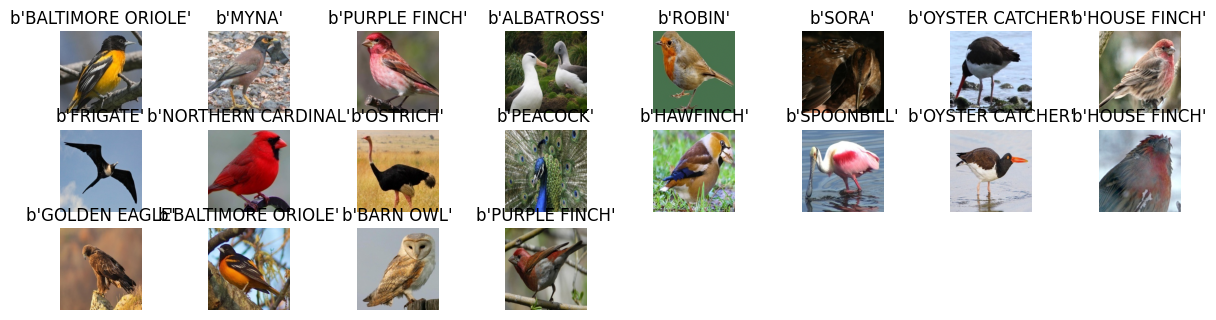

In [ ]:
# # Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for plot_idx in range(20):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    idx = (plot_idx * 373) % len(all_data)  # Gets a "random" index in the dataset


    # for this code, use `idx` as the dataset index
    cur_image = all_data.images[idx]
    cur_label = all_data.labels[idx]
    cur_class = all_data.classes[all_data.labels[idx]]

    ax.title.set_text(cur_class)
    plt.axis('off')
    plt.imshow(cur_image)

## Model structure

Here's where you'll define the structure of your neural network. Refer back to earlier workshop notebooks for reference.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class BirdModel(nn.Module):
    def __init__(self, num_classes=20):
        super(BirdModel, self).__init__()
        input_channels = 3
        height = 224
        width = 224

        self.conv = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        #######
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.bn4 = nn.BatchNorm2d(128)

        # Calculate the flattened size based on the number of channels and spatial dimensions

        # Instantiate the linear layer with the correct input size
        self.fc1 = nn.Linear(128 * 12 * 12, 128)

        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv(x))))
        #print(x.size())
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        ########
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        print(x.size())

        # Flatten the tensor based on the calculated flattened size
        x = x.reshape(-1, 128 * 12 * 12)
        #print(x.size())

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        x = F.softmax(x, dim=1)

        return x


## Training setup

### Hyperparameters

Here's where we'll define our hyperparameters. We put them all in this cell for ease of readability; if you choose to add more hyperparameters, we suggest you add them here.

As you're tuning your model, change these values how you see fit!

In [ ]:
batch_size = 40
learning_rate = 0.0001
num_epochs = 30

### Data Augmentation

If you choose to use data augmentation, add your augmentation transforms here.

In [ ]:
from torchvision import transforms

aug = torchvision.transforms.Compose([
    # currently empty (no augmentation). add any transforms here if you wish!
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Data loaders

Here we'll create the data loaders for the train and validation set. To split `all_data` into the training and validation sets, read the PyTorch documentation for `random_split`: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

Be sure to pass in the `batch_size` hyperparameter to the DataLoaders, and be sure to shuffle the training data loader!

In [ ]:
# total_samples = len(all_data)

# train_len = 0.2 * total_samples
# val_len = 0.8 * total_samples

train_set, val_set = torch.utils.data.random_split(all_data, [0.2, 0.8])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


## Training

It's time to train our model!

### Evaluation function

First, let's create a function that evaluates the accuracy of a model on a specified dataset. We provide some of the skeleton code, but you'll be coding this one on your own!

Be sure to call `.to(device=device)` on any data tensors to make sure PyTorch is using the GPU.

In [ ]:
# split is a variable you can set as the "name" of the dataset (either "train" or "val")
def evaluate(model, data_loader, name="val"):
    correct = 0  # number of correct predictions
    total = 0    # total number of examples in the data loader

    ######## BEGIN YOUR CODE HERE ########
    model.eval()
    with torch.no_grad():
      for inputs, batch_labels in data_loader:
        inputs, labels = inputs.to(device=device), batch_labels.to(device=device)
        inputs = inputs.permute(0, 3, 1, 2)  # Assuming your input is in the format [batch_size, height, width, channels]
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    ######### END YOUR CODE HERE #########

    print(f'Accuracy of the network on the {total} {name} images: {100 * correct / total}%')

### Training loop

This is it: this is where your model learns! You'll also be implementing this function on your own. A couple tips:
* Be sure to apply augmentations to your data if you're using them
* Be sure to call `.to(device=device)` on your model and any data tensors to make sure PyTorch is using the GPU
* Call `evaluate` on both the train and validation data loaders after each epoch

In [ ]:
device = torch.device("cuda")
model = BirdModel().to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    for i, (inputs, batch_labels) in enumerate(train_loader, 0):
        inputs, batch_labels = inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.permute(0, 3, 1, 2)
        #print(inputs.shape)
        # Forward pass
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        batch_labels = batch_labels.long()
        loss = criterion(outputs, batch_labels)
        print(f"Loss: {loss}")

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # can tune this value
        optimizer.step()

    model.eval()  # Set the model to evaluation mode
    evaluate(model, val_loader, name="Validation")

    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    ######### END YOUR CODE HERE #########

end_time = time.time()
print(f"Total training time: {end_time - start_time} sec")

torch.Size([40, 128, 12, 12])
Loss: 2.9978160858154297
torch.Size([40, 128, 12, 12])
Loss: 2.991697072982788
torch.Size([40, 128, 12, 12])
Loss: 3.002187490463257
torch.Size([40, 128, 12, 12])
Loss: 2.9895825386047363
torch.Size([40, 128, 12, 12])
Loss: 2.988550901412964
torch.Size([40, 128, 12, 12])
Loss: 3.0000805854797363
torch.Size([40, 128, 12, 12])
Loss: 2.9957737922668457
torch.Size([40, 128, 12, 12])
Loss: 2.9959053993225098
torch.Size([40, 128, 12, 12])
Loss: 2.9955966472625732
torch.Size([40, 128, 12, 12])
Loss: 2.985217571258545
torch.Size([40, 128, 12, 12])
Loss: 2.996253728866577
torch.Size([40, 128, 12, 12])
Loss: 2.9853458404541016
torch.Size([40, 128, 12, 12])
Loss: 2.975630283355713
torch.Size([40, 128, 12, 12])
Loss: 2.9801414012908936
torch.Size([40, 128, 12, 12])
Loss: 3.0012118816375732
torch.Size([23, 128, 12, 12])
Loss: 2.956559181213379
torch.Size([40, 128, 12, 12])
torch.Size([40, 128, 12, 12])
torch.Size([40, 128, 12, 12])
torch.Size([40, 128, 12, 12])
torch.S

### Saving model weights

Save your weights! Your final model's weights will be one component of your submission. We recommend saving weights with a recognizable name, such as the date and a short description of the structure of your model (e.g. `"2023_10_25_3LayerCNN"`)

In [ ]:
model_name = "12_01_CNN_3"  ### CHANGE THIS NAME EACH TIME YOU SAVE WEIGHTS! ###

date_str = date.today().strftime("%Y_%m_%d")
model_weights_filename = f"{date_str}_{model_name}.pt"

torch.save(model.state_dict(), f"{model_weights_filename}")
print(f"Model weights saved as {model_weights_filename}")

Model weights saved as 2025_03_06_12_01_CNN_3.pt


### Refining your model

Now that you've trained a basic model, it's time to see if you can improve its accuracy. Feel free to change anything – the model structure, hyperparameters, augmentation – or try employing training strategies like regularization or early stopping. Get creative!

## Predict functions

These functions will let us run the test set through your model. It is **incredibly important** that you implement these functions!

`predict` should load the image at the specified path, run it through the model (variable provided as a parameter), and output the **predicted label** (the single numerical value between 0 and 19) – *not* the class name (e.g. the name of the bird).

In [ ]:
def load_model():
    model_path = "2023_12_02_12_01_CNN_3.pt"

    model = BirdModel()
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def predict(model, image_path):
    prediction = None
    ######## BEGIN YOUR CODE HERE ########

    model = load_model()
    img = Image.open(image_path)
    input_tensor = transform(img).to("cuda")

    bird = BirdDataset()

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    prediction = bird.labels[predicted_idx]

    ######### END YOUR CODE HERE #########
    return prediction